<a href="https://colab.research.google.com/github/vindhya1103/GenAI/blob/main/GAI_Exp6_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 6: Implement GAN architecture on MNIST dataset to recognize the handwritten digits

Ref: https://www.kdnuggets.com/2016/07/mnist-generative-adversarial-model-keras.html

## Description

complete it

## Program


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

# Load MNIST data
(X_train,y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [ ]:
# Normalize data
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

(60000, 28, 28, 1)


In [ ]:
# Define discriminator
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (4, 4), strides=2, padding='same', input_shape=(28, 28, 1))) # Added input_shape
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, (4, 4), strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid')) # Corrected activation to sigmoid
    return model

# Compile discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy']) # Added metrics
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        1088      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 128)         131200    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 1)                 6273      
                                                                 
Total params: 138561 (541.25 KB)
Trainable params: 138

In [ ]:
# Define generator
def build_generator():
    model = Sequential()
    model.add(Dense(7*7*128, input_dim=100))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128))) # Corrected Reshape parameters
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', activation='tanh'))
    return model

# Combine generator and discriminator into a single model
generator = build_generator()
generator.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        131136    
 anspose)                                                        
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 1)         1025      
 Transpose)                                           

In [ ]:
# Input Latent Variable
z = Input(shape=(100,))
# Output of generator
img = generator(z)
# Freeze Discriminator
discriminator.trainable = False
# Give output of Generator to the Discriminator
validity = discriminator(img)

# Build DCGAN
gan = Model(z, validity)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

gan.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_4 (Sequential)   (None, 28, 28, 1)         765633    
                                                                 
 sequential_3 (Sequential)   (None, 1)                 138561    
                                                                 
Total params: 904194 (3.45 MB)
Trainable params: 765633 (2.92 MB)
Non-trainable params: 138561 (541.25 KB)
_________________________________________________________________


In [ ]:
# Train DCGAN
epochs = 5000
batch_size = 64
d_loss_all, g_loss_all = [], []
for epoch in range(epochs):
    # Select a random batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_images = X_train[idx]

    # Generate fake images
    noise = np.random.normal(0, 1, (batch_size, 100))
    fake_images = generator.predict(noise)

    # Train discriminator
    d_loss_real = discriminator.train_on_batch(real_images, np.ones(batch_size))
    d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros(batch_size))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    d_loss_all.append(d_loss[0])

    # Train generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = gan.train_on_batch(noise, np.ones(batch_size))
    g_loss_all.append(g_loss)

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} \t Discriminator Loss: {d_loss[0]} \t Generator Loss: {g_loss}")


Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 24ms/step
Epoch: 100 	 Discriminator Loss: 0.26038116961717606 	 Generator Loss: 3.361185073852539
2/2 [==============================] - 0s 29ms/step
Epoch: 200 	 Discriminator Loss: 0.35204964876174927 	 Generator Loss: 2.2269768714904785
2/2 [==============================] - 0s 28ms/step
Epoch: 300 	 Discriminator Loss: 0.4209239333868027 	 Generator Loss: 1.593562126159668
2/2 [==============================] - 0s 47ms/step
Epoch: 400 	 Discriminator Loss: 0.47932517528533936 	 Generator Loss: 1.837573528289795
2/2 [==============================] - 0s 28ms/step
Epoch: 500 	 Discriminator Loss: 0.547435462474823 	 Generator Loss: 1.7001011371612549
2/2 [==============================] - 0s 30ms/step
Epoch: 600 	 Discriminator Loss: 0.5843941569328308 	 Generator Loss: 1.7660603523254395
2/2 [==============================] - 0s 29ms/step
Epoch: 700 	 Discriminator Loss: 0.5535965859889984 

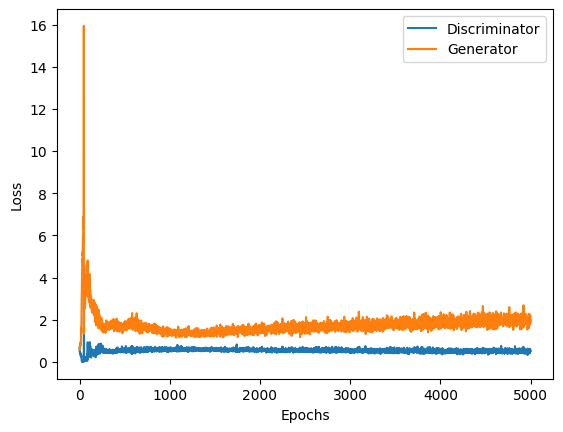

In [ ]:
plt.plot(d_loss_all)
plt.plot(g_loss_all)
plt.legend(('Discriminator','Generator'))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

4/4 [==============================] - 0s 19ms/step


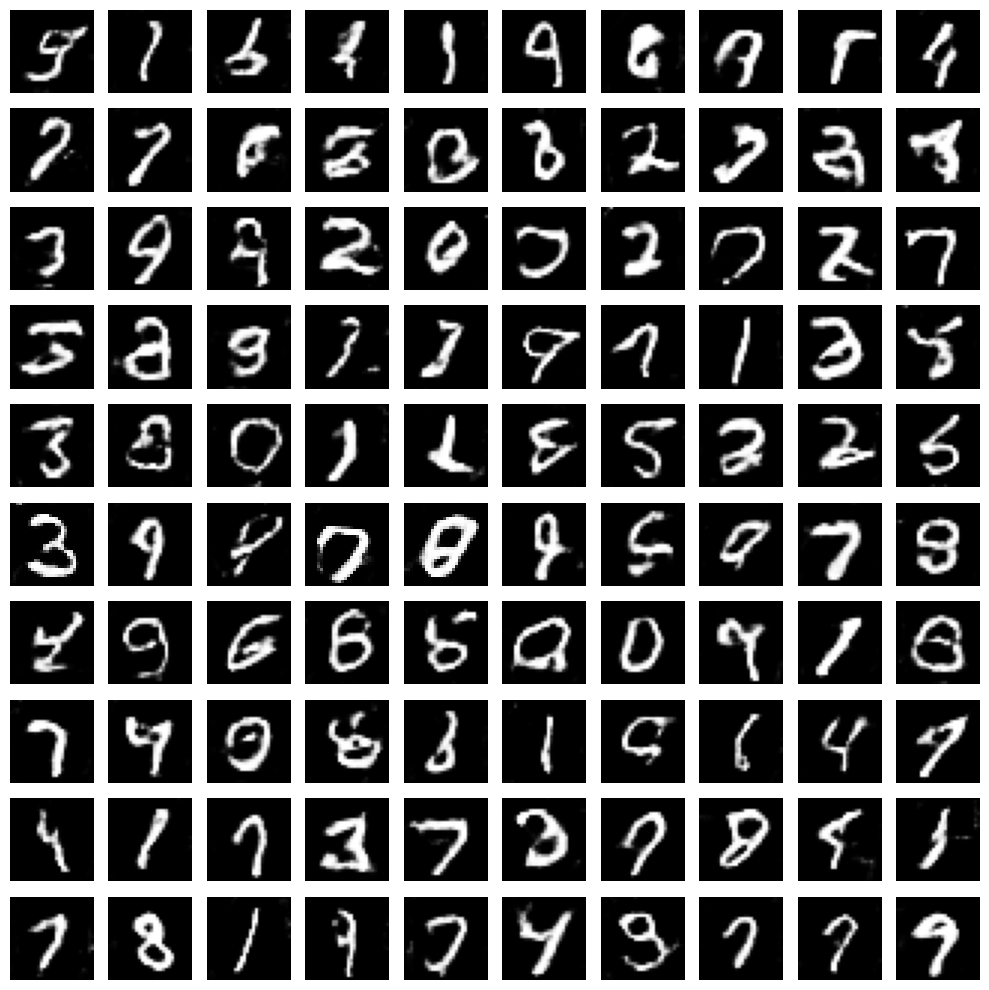

In [ ]:
# Generate images
noise = np.random.normal(0, 1, (100, 100))
generated_images = generator.predict(noise)

# Display generated images
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()